# Fast Neural Style Transfer

In [1]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
DATASET = "../coco_2017/"
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE), 
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(), tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    vgg_model = vgg.vgg16(pretrained=True)
    vgg_model.to(device)
    loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

In [25]:
STYLE_IMAGE = "../style_images/rain-princess-cropped.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
with torch.no_grad():
    style_img_tensor = transforms.Compose([
        transforms.Resize(IMAGE_SIZE* 2),
        transforms.ToTensor(),
        tensor_normalizer()]
    )(style_img).unsqueeze(0)
    # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    style_img_tensor = style_img_tensor.to(device)

Sanity check:

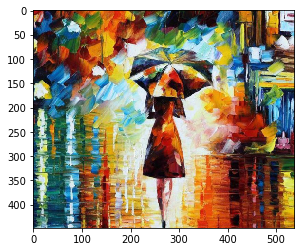

In [26]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [27]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y) for y in style_loss_features]

In [11]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [12]:
for i in range(len(style_loss_features)):
    print(i, np.mean(gram_style[i].cpu().numpy()))

0 0.013750292
1 0.022934055
2 0.01356209
3 0.0006482121


In [13]:
for i in range(len(style_loss_features)):
    print(i, np.mean(style_loss_features[i].cpu().numpy()))

0 0.8946184
1 1.6583
2 1.7636366
3 0.50923604


In [14]:
for i in range(len(style_loss_features)):
    print(i, gram_style[i].numel(), gram_style[i].size())

0 4096 torch.Size([1, 64, 64])
1 16384 torch.Size([1, 128, 128])
2 65536 torch.Size([1, 256, 256])
3 262144 torch.Size([1, 512, 512])


## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [21]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [22]:
%mkdir -p debug

In [5]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [28]:
torch.set_default_tensor_type('torch.FloatTensor')

CONTENT_WEIGHT = 1
STYLE_WEIGHTS = np.array([1e3, 1e5, 1e3, 2e4]) * 5
LOG_INTERVAL = 100
REGULARIZATION = 1e-6

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)
transformer.train()
for epoch in range(2):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = x.to(device)       
        y = transformer(x)
        with torch.no_grad():
            xc = x.detach()

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        with torch.no_grad():
            f_xc_c = features_xc[1].detach()

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for l, weight in enumerate(STYLE_WEIGHTS):
            gram_s = gram_style[l]
            gram_y = gram_matrix(features_y[l])
            style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss
        agg_style_loss += style_loss
        agg_reg_loss += reg_loss

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            transformer.eval()
            y = transformer(x)
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))
            transformer.train()

Wed Jun 20 02:24:38 2018 [400/40670] content: 10.866086  style: 17.435951  reg: 0.212229  total: 28.514267
Wed Jun 20 02:25:34 2018 [800/40670] content: 10.683635  style: 6.764901  reg: 0.232329  total: 17.680864
Wed Jun 20 02:26:30 2018 [1200/40670] content: 10.493557  style: 5.385999  reg: 0.235846  total: 16.115400
Wed Jun 20 02:27:25 2018 [1600/40670] content: 10.105755  style: 4.577156  reg: 0.238635  total: 14.921546
Wed Jun 20 02:28:20 2018 [2000/40670] content: 9.757328  style: 4.139169  reg: 0.237737  total: 14.134233
Wed Jun 20 02:29:15 2018 [2400/40670] content: 9.610765  style: 3.910936  reg: 0.239416  total: 13.761117
Wed Jun 20 02:30:11 2018 [2800/40670] content: 9.261939  style: 3.690016  reg: 0.238415  total: 13.190371
Wed Jun 20 02:31:06 2018 [3200/40670] content: 9.134980  style: 3.457073  reg: 0.240034  total: 12.832088
Wed Jun 20 02:32:01 2018 [3600/40670] content: 8.867087  style: 3.423355  reg: 0.239351  total: 12.529794
Wed Jun 20 02:32:58 2018 [4000/40670] conte

Wed Jun 20 03:36:22 2018 [31600/40670] content: 5.595276  style: 2.269572  reg: 0.220679  total: 8.085526
Wed Jun 20 03:37:17 2018 [32000/40670] content: 5.472049  style: 2.270876  reg: 0.221277  total: 7.964203
Wed Jun 20 03:38:11 2018 [32400/40670] content: 5.557646  style: 2.298515  reg: 0.220827  total: 8.076989
Wed Jun 20 03:39:05 2018 [32800/40670] content: 5.473544  style: 2.302678  reg: 0.221192  total: 7.997415
Wed Jun 20 03:39:59 2018 [33200/40670] content: 5.507867  style: 2.312637  reg: 0.220420  total: 8.040924
Wed Jun 20 03:40:53 2018 [33600/40670] content: 5.519176  style: 2.280027  reg: 0.220323  total: 8.019526
Wed Jun 20 03:41:49 2018 [34000/40670] content: 5.517631  style: 2.285858  reg: 0.219906  total: 8.023396
Wed Jun 20 03:42:44 2018 [34400/40670] content: 5.482558  style: 2.261017  reg: 0.219764  total: 7.963338
Wed Jun 20 03:43:39 2018 [34800/40670] content: 5.497257  style: 2.246736  reg: 0.218833  total: 7.962826
Wed Jun 20 03:44:34 2018 [35200/40670] content

Wed Jun 20 03:58:00 2018 [400/40670] content: 5.251837  style: 2.111455  reg: 0.219170  total: 7.582462
Wed Jun 20 03:58:56 2018 [800/40670] content: 5.269355  style: 2.131667  reg: 0.219297  total: 7.620320
Wed Jun 20 03:59:52 2018 [1200/40670] content: 5.221152  style: 2.088755  reg: 0.219370  total: 7.529277
Wed Jun 20 04:00:48 2018 [1600/40670] content: 5.241946  style: 2.150815  reg: 0.218886  total: 7.611646
Wed Jun 20 04:01:44 2018 [2000/40670] content: 5.271947  style: 2.135766  reg: 0.218892  total: 7.626606
Wed Jun 20 04:02:40 2018 [2400/40670] content: 5.208828  style: 2.172785  reg: 0.218736  total: 7.600349
Wed Jun 20 04:03:36 2018 [2800/40670] content: 5.274389  style: 2.155924  reg: 0.219203  total: 7.649517
Wed Jun 20 04:04:32 2018 [3200/40670] content: 5.187806  style: 2.202543  reg: 0.217731  total: 7.608080
Wed Jun 20 04:05:28 2018 [3600/40670] content: 5.126993  style: 2.135131  reg: 0.218381  total: 7.480505
Wed Jun 20 04:06:24 2018 [4000/40670] content: 5.229142  

Wed Jun 20 05:09:18 2018 [31600/40670] content: 4.814108  style: 1.928071  reg: 0.215826  total: 6.958005
Wed Jun 20 05:10:13 2018 [32000/40670] content: 4.839656  style: 1.996722  reg: 0.216046  total: 7.052423
Wed Jun 20 05:11:08 2018 [32400/40670] content: 4.871180  style: 1.976956  reg: 0.216054  total: 7.064189
Wed Jun 20 05:12:04 2018 [32800/40670] content: 4.792382  style: 1.932725  reg: 0.215802  total: 6.940908
Wed Jun 20 05:12:59 2018 [33200/40670] content: 4.811086  style: 1.955748  reg: 0.215083  total: 6.981916
Wed Jun 20 05:13:54 2018 [33600/40670] content: 4.828643  style: 1.994999  reg: 0.215414  total: 7.039056
Wed Jun 20 05:14:49 2018 [34000/40670] content: 4.799549  style: 1.959592  reg: 0.216341  total: 6.975482
Wed Jun 20 05:15:44 2018 [34400/40670] content: 4.842042  style: 1.927840  reg: 0.215650  total: 6.985532
Wed Jun 20 05:16:38 2018 [34800/40670] content: 4.775887  style: 1.878707  reg: 0.215835  total: 6.870428
Wed Jun 20 05:17:33 2018 [35200/40670] content

In [29]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

40670

In [30]:
transformer = transformer.eval()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


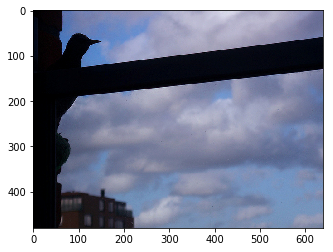

In [35]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([
                                
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

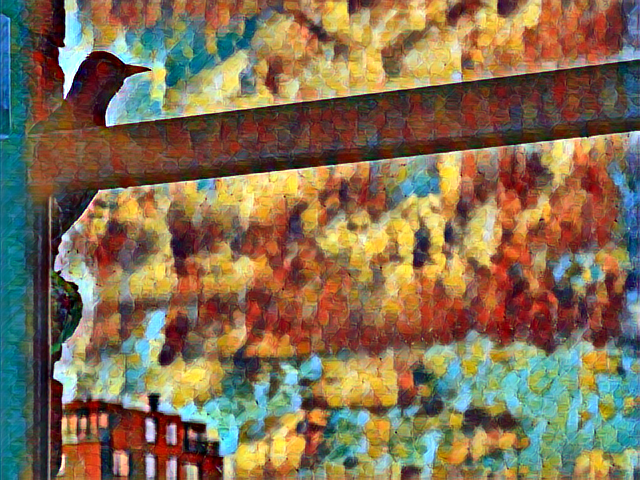

In [36]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


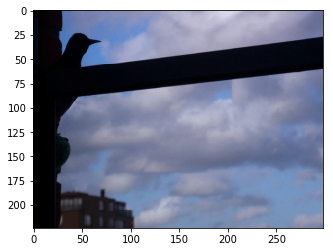

In [37]:
img = Image.open(fnames[40]).convert('RGB')
transform = transforms.Compose([
                                transforms.Resize(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

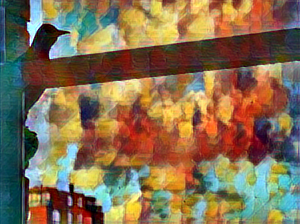

In [38]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

In [39]:
save_model_path = "../models/model_rain_princess_cropped.pth"
torch.save(transformer.state_dict(), save_model_path)

In [7]:
save_model_path = "../models/model_rain_princess_cropped.pth"
transformer.load_state_dict(torch.load(save_model_path))

torch.Size([1, 3, 512, 512])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


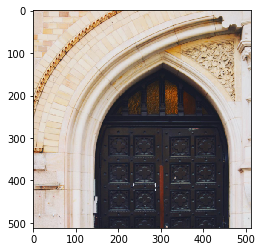

In [8]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

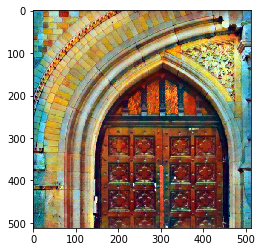

In [9]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


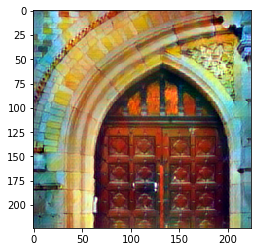

In [10]:
img = Image.open("../content_images/amber.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [11]:
output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
output_img.save("amber.png")